In [1]:
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import osmnx as ox
from shapely.geometry import Point, Polygon

from planar import *

ox.config(use_cache=True, log_console=True)
%matplotlib inline

In [2]:
# config
query = 'Oakland, California, USA'
n = 200
distance = 805
network_type = 'drive'

## Random points across a single city

In [3]:
def random_points_within(poly, n):
    
    np.random.seed(0)
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    
    while len(points) < n:
        rand_x = np.random.uniform(min_x, max_x)
        rand_y = np.random.uniform(min_y, max_y)
        rand_pt = Point((rand_x, rand_y))
        if (rand_pt.within(poly)):
            points.append((rand_x, rand_y))

    return points

In [4]:
gdf = ox.gdf_from_place(query)
poly = gdf.loc[0, 'geometry']
points = np.array(random_points_within(poly, n=n))

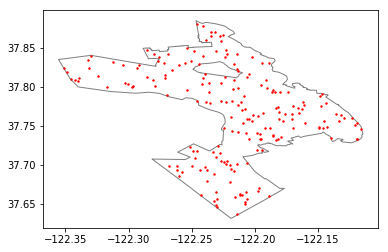

In [5]:
x = points[:,0]
y = points[:,1]
fig, ax = plt.subplots()
gdf.plot(ax=ax, facecolor='w', edgecolor='gray')
ax.scatter(x=x, y=y, s=2, c='r')
plt.show()

In [6]:
places = {}
for i, point in enumerate(points):
    name = '{:002d}_{}'.format(i, query)
    latlng = (point[1], point[0])
    places[name] = latlng

In [7]:
results = []
for name, coords in places.items():

    try:

        ox.log('working on {} - {}.'.format(name, distance))
        start_time = time.time()
        G = get_graph(coords, distance, network_type=network_type)

        # get a special buffered graph for planar analysis
        buffer = 500
        G_buff = get_graph(coords, distance + buffer, network_type=network_type)

        # get a bounding box to trim things square
        north, south, east, west = ox.bbox_from_point(coords, distance)
        bbox = Polygon([(west, north), (west, south), (east, south), (east, north)])

        # how many planar line intersections are there?
        planar_intersections = calculate_planar_intersections(G_buff, bbox)
        count_planar_intersections = len(planar_intersections)

        # how many nonplanar graph edge intersections are there?
        nonplanar_intersections = calculate_nonplanar_intersections(G, bbox)
        count_nonplanar_intersections = len(nonplanar_intersections)

        # how many cleaned, clustered intersections are there?
        cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections, G.graph['crs'])
        count_cleaned_intersections = len(cleaned_intersections)

        # how does planarity affect average edge length?
        mean_edge_length, mean_planar_segment_length, edge_length_ratio = calculate_edge_length_ratios(G, planar_intersections)

        if count_nonplanar_intersections > 0:
            # planar line intersections overcounts nonplanar graph edge intersections by xx%
            # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
            planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections
        else:
            planar_nonplanar_overcount = None #avoid divide by zero errors

        if count_cleaned_intersections > 0:
            # edge intersections overcounts street intersections by xx%
            nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

            # line intersections overcounts street intersections by xx%
            planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections
        else:
            planar_cleaned_overcount = None #avoid divide by zero errors
            nonplanar_cleaned_overcount = None

        # assemble the results
        result = {'name' : name,
                  'coords' : coords,
                  'distance' : distance,
                  'network_type' : network_type,
                  'nodes' : len(G.nodes()),
                  'count_planar_intersections' : count_planar_intersections,
                  'count_nonplanar_intersections' : count_nonplanar_intersections,
                  'count_cleaned_intersections' : count_cleaned_intersections,
                  'overcount_planar_nonplanar' : planar_nonplanar_overcount,
                  'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
                  'overcount_planar_cleaned' : planar_cleaned_overcount,
                  'mean_edge_length' : mean_edge_length,
                  'mean_planar_segment_length' : mean_planar_segment_length,
                  'edge_length_ratio' : edge_length_ratio,
                  'runtime' : time.time() - start_time}
        results.append(result)

    except Exception as e:
        print(name, e)

09_Oakland, California, USA There are no data elements in the response JSON objects
10_Oakland, California, USA There are no data elements in the response JSON objects
calculate_cleaned_intersections error You cannot project an empty GeoDataFrame.
13_Oakland, California, USA You cannot project an empty GeoDataFrame.
14_Oakland, California, USA There are no data elements in the response JSON objects
17_Oakland, California, USA There are no data elements in the response JSON objects
28_Oakland, California, USA There are no data elements in the response JSON objects
29_Oakland, California, USA There are no data elements in the response JSON objects
31_Oakland, California, USA There are no data elements in the response JSON objects
calculate_cleaned_intersections error You cannot project an empty GeoDataFrame.
36_Oakland, California, USA You cannot project an empty GeoDataFrame.
38_Oakland, California, USA There are no data elements in the response JSON objects
40_Oakland, California, USA 

In [8]:
df = pd.DataFrame(results)
df['overcount_planar_nonplanar'].mean()

1.0694574130649634

In [9]:
df.to_csv('data/city_samples.csv')
df.head()

,coords,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,distance,edge_length_ratio,mean_edge_length,mean_planar_segment_length,name,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,runtime
0,"(37.8132704666, -122.223502244)",156,176,176,805,0.999988,136.536593,136.534914,"00_Oakland, California, USA",drive,245,1.128205,1.128205,1.000000,7.465080
1,"(37.7701588187, -122.210489049)",173,200,206,805,0.977546,126.299011,123.463090,"01_Oakland, California, USA",drive,269,1.156069,1.190751,1.030000,7.736993
2,"(37.7957289276, -122.25369165)",172,196,199,805,0.988097,117.234219,115.838832,"02_Oakland, California, USA",drive,240,1.139535,1.156977,1.015306,7.583998
3,"(37.7661115178, -122.164909795)",137,147,149,805,0.990677,142.153314,140.828024,"03_Oakland, California, USA",drive,200,1.072993,1.087591,1.013605,4.949770
4,"(37.8298107167, -122.244568025)",143,168,168,805,0.999984,109.973009,109.971298,"04_Oakland, California, USA",drive,226,1.174825,1.174825,1.000000,6.205001


In [10]:
cols = ['overcount_planar_nonplanar', 'overcount_nonplanar_cleaned', 'overcount_planar_cleaned', 'edge_length_ratio']
table = df[cols].describe().T.round(3)

In [11]:
print(table.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &   mean &    std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
overcount\_planar\_nonplanar  &  148.0 &  1.069 &  0.120 &  1.000 &  1.000 &  1.032 &  1.085 &  1.692 \\
overcount\_nonplanar\_cleaned &  148.0 &  1.158 &  0.164 &  1.000 &  1.077 &  1.124 &  1.178 &  2.000 \\
overcount\_planar\_cleaned    &  148.0 &  1.240 &  0.227 &  1.000 &  1.112 &  1.166 &  1.265 &  2.000 \\
edge\_length\_ratio           &  148.0 &  0.959 &  0.065 &  0.631 &  0.948 &  0.983 &  1.000 &  1.000 \\
\bottomrule
\end{tabular}



## Get the whole city

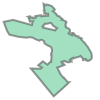

In [12]:
gdf = ox.gdf_from_place(query)
poly = gdf.loc[0, 'geometry']
poly

In [13]:
start_time = time.time()
G = ox.graph_from_place(query, network_type=network_type,
                        simplify=True, truncate_by_edge=True, retain_all=True)

# get a special buffered graph for planar analysis
buffer = 500
G_buff = ox.graph_from_place(query, network_type=network_type, buffer_dist=buffer,
                             simplify=True, truncate_by_edge=True, retain_all=True)

# how many planar line intersections are there?
planar_intersections = calculate_planar_intersections(G_buff, bbox=poly)
count_planar_intersections = len(planar_intersections)

# how many nonplanar graph edge intersections are there?
nonplanar_intersections = calculate_nonplanar_intersections(G, bbox=poly)
count_nonplanar_intersections = len(nonplanar_intersections)

# how many cleaned, clustered intersections are there?
cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections, G.graph['crs'])
count_cleaned_intersections = len(cleaned_intersections)

# how does planarity affect average edge length?
mean_edge_length, mean_planar_segment_length, edge_length_ratio = calculate_edge_length_ratios(G, planar_intersections)

if count_nonplanar_intersections > 0:
    # planar line intersections overcounts nonplanar graph edge intersections by xx%
    # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
    planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections
else:
    planar_nonplanar_overcount = None #avoid divide by zero errors

if count_cleaned_intersections > 0:
    # edge intersections overcounts street intersections by xx%
    nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

    # line intersections overcounts street intersections by xx%
    planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections
else:
    planar_cleaned_overcount = None #avoid divide by zero errors
    nonplanar_cleaned_overcount = None

# assemble the results
result = {'name' : query,
          'network_type' : network_type,
          'nodes' : len(G.nodes()),
          'count_planar_intersections' : count_planar_intersections,
          'count_nonplanar_intersections' : count_nonplanar_intersections,
          'count_cleaned_intersections' : count_cleaned_intersections,
          'overcount_planar_nonplanar' : planar_nonplanar_overcount,
          'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
          'overcount_planar_cleaned' : planar_cleaned_overcount,
          'mean_edge_length' : mean_edge_length,
          'mean_planar_segment_length' : mean_planar_segment_length,
          'edge_length_ratio' : edge_length_ratio,
          'runtime' : time.time() - start_time}

In [14]:
# results for the entire city
pd.Series(result)

count_cleaned_intersections                          6470
count_nonplanar_intersections                        7393
count_planar_intersections                           8050
edge_length_ratio                                0.935786
mean_edge_length                                  132.851
mean_planar_segment_length                         124.32
name                             Oakland, California, USA
network_type                                        drive
nodes                                                8433
overcount_nonplanar_cleaned                       1.14266
overcount_planar_cleaned                           1.2442
overcount_planar_nonplanar                        1.08887
runtime                                           6399.52
dtype: object